In [1]:
import graphviz 
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import tree

import utils

from utils import local_data
from utils import window
from utils import Scale, give_error
from utils import location_station, find_set_sunrise, find_set_sunset

%matplotlib inline
warnings.filterwarnings('ignore')

latter_size = 14
plt.rcParams['legend.fontsize'] = latter_size 
plt.rcParams['font.size'] = latter_size 
plt.rcParams['axes.labelsize'] = latter_size
plt.rcParams['xtick.labelsize'] = latter_size
plt.rcParams['ytick.labelsize'] = latter_size

In [2]:
df = pd.read_pickle('./data/sj2_analise.pkl')

In [3]:
df.head()

,vtec,vtec_dt,vtec_dt2,gvtec1,gvtec1_dt,gvtec2,gvtec2_dt,s4
2013-12-01 03:30:00,33.624428,-0.428246,-0.020502,-3.216613,0.002355,1.826065,1.991653,0.163334
2013-12-01 03:40:00,33.205025,-0.546589,-0.118343,-3.122300,0.130198,4.588494,2.530373,0.165397
2013-12-01 03:50:00,32.539631,-0.772594,-0.226005,-2.810556,0.280756,7.786990,2.862830,0.168683
2013-12-01 04:00:00,31.469337,-1.082859,-0.310265,-2.320938,0.399753,10.972091,2.894375,0.173552
2013-12-01 04:10:00,29.995466,-1.429647,-0.346788,-1.764129,0.443303,13.734955,2.621609,0.178917


# SVM para regressão
## Completa

In [4]:
instances_set = ['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt']
scaler = StandardScaler()
scaler.fit(X=df[instances_set].values) 
X = scaler.transform(X=df[instances_set].values)
y = df['s4'].values

X_train, X_test, y_train, y_test = train_test_split(X[0:12000], y[0:12000], test_size=0.30, random_state=42)
index = df.index.values[12000:12772]

The scores for the k-fold crossvalidation was:
[-0.0026473  -0.00282942 -0.002655   -0.00276079 -0.0027879  -0.00268281
 -0.00286417 -0.00235551 -0.00268094 -0.00263356] 

O erro quadrático médio foi: 0.002478
O erro quadrático total foi: 2.986976
O maior erro por previsão foi: 0.265615
O erro relativo foi: 21.239728%
O número de verdadeiros negativos foi: 1571
O número de verdadeiros positivos foi: 367
O número de falsos negativos foi: 10
O número de falsos positivos foi: 1652
O POD foi: 0.973475
O FAR foi: 0.818227
A ACC foi: 0.538333
O kappa foi: 0.047993

Error for the time series sample:
O erro quadrático médio foi: 0.007980
O erro quadrático total foi: 2.320827
O maior erro por previsão foi: 0.496674
O erro relativo foi: 29.184886%
O número de verdadeiros negativos foi: 302
O número de verdadeiros positivos foi: 79
O número de falsos negativos foi: 5
O número de falsos positivos foi: 289
O POD foi: 0.940476
O FAR foi: 0.785326
A ACC foi: 0.564444
O kappa foi: 0.053423


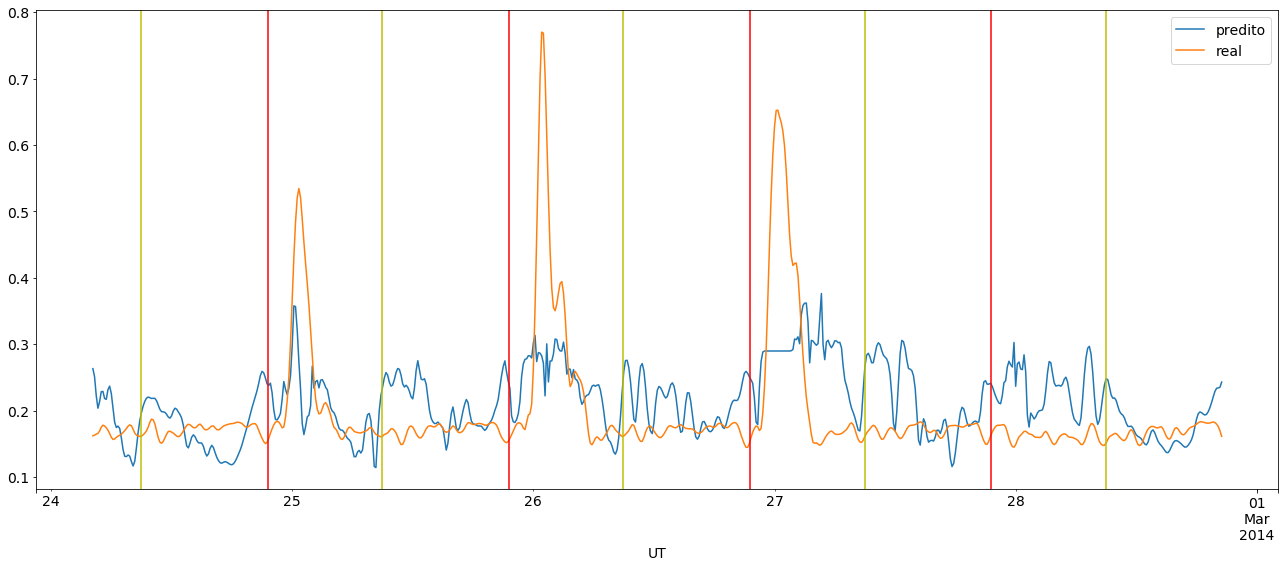

In [5]:
# generate model, use k-fold crossvalidation and print scores
model = SVR()
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print('The scores for the k-fold crossvalidation was:')
print(scores, '\n')

# generate final model, and avaliate a test set
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
give_error(y_test, y_predict);
print()

# use the final model to avaliate the error in a sample of the time series
df_aux = pd.DataFrame(index=index)
df_aux['predito'] = model.predict(X[12000:12772])
df_aux['real'] = y[12000:12772]

print('Error for the time series sample:')
give_error(df_aux['real'].values, df_aux['predito'].values);

# plot the time series predict against the real values
ax = df_aux.plot(figsize=(18, 8));
plt.xlabel('UT')

lat, long = location_station('sj2')
set_of_sunrise = find_set_sunrise(df_aux, lat, long)
set_of_sunset = find_set_sunset(df_aux, lat, long)
for i in set_of_sunrise:
    ax.axvline(x=i, color='y')
for i in set_of_sunset[0:-1]:
    ax.axvline(x=i, color='r')

plt.tight_layout()
plt.savefig('./images/regression_svm.eps', format='eps', dpi=1000)

## Sem vtec

In [6]:
instances_set = ['vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt']
scaler = StandardScaler()
scaler.fit(X=df[instances_set].values) 
X = scaler.transform(X=df[instances_set].values)
y = df['s4'].values

X_train, X_test, y_train, y_test = train_test_split(X[0:12000], y[0:12000], test_size=0.30, random_state=42)
index = df.index.values[12000:12772]

The scores for the k-fold crossvalidation was:
[-0.00290779 -0.00284324 -0.00262675 -0.00307112 -0.00301072 -0.00311564
 -0.00289584 -0.00284464 -0.00316742 -0.00292326] 

O erro quadrático médio foi: 0.002930
O erro quadrático total foi: 3.247679
O maior erro por previsão foi: 0.282451
O erro relativo foi: 24.345703%
O número de verdadeiros negativos foi: 1410
O número de verdadeiros positivos foi: 368
O número de falsos negativos foi: 9
O número de falsos positivos foi: 1813
O POD foi: 0.976127
O FAR foi: 0.831270
A ACC foi: 0.493889
O kappa foi: 0.052459

Error for the time series sample:
O erro quadrático médio foi: 0.008617
O erro quadrático total foi: 2.411770
O maior erro por previsão foi: 0.482412
O erro relativo foi: 34.353222%
O número de verdadeiros negativos foi: 183
O número de verdadeiros positivos foi: 79
O número de falsos negativos foi: 5
O número de falsos positivos foi: 408
O POD foi: 0.940476
O FAR foi: 0.837782
A ACC foi: 0.388148
O kappa foi: 0.072751


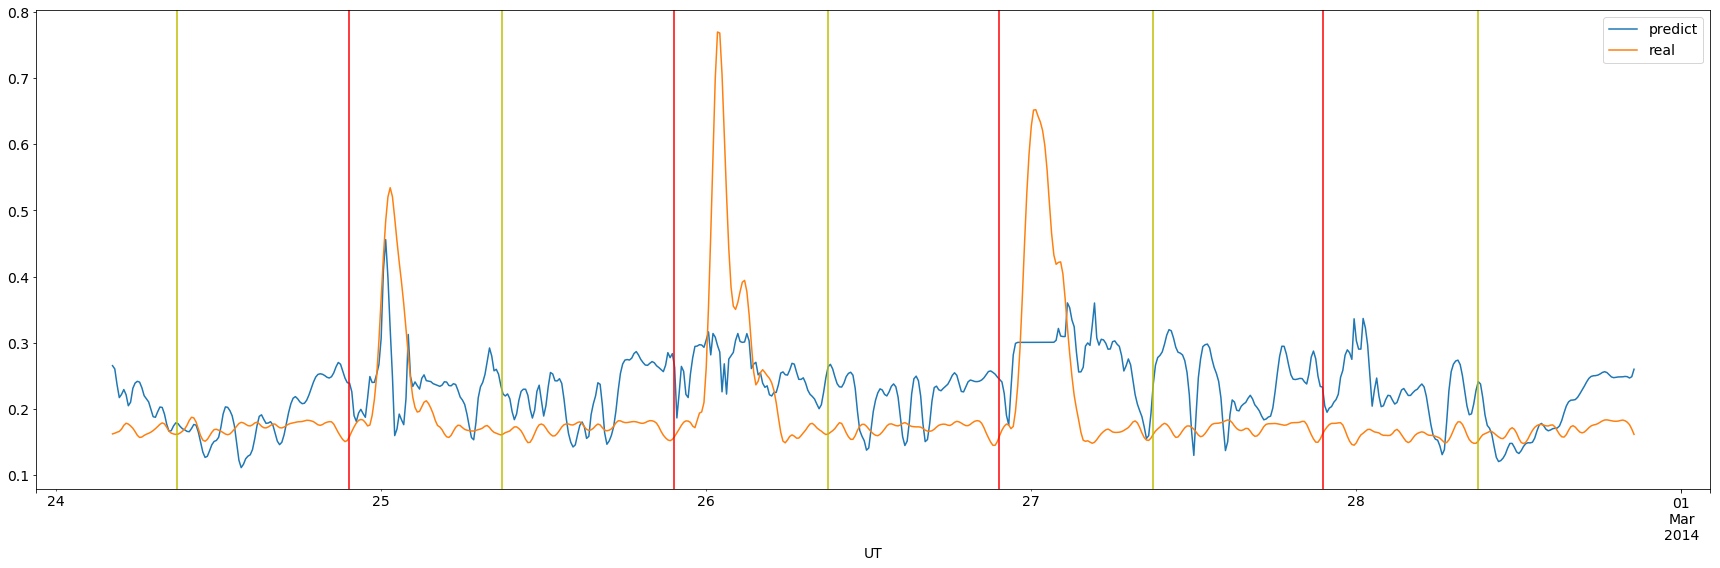

In [7]:
# generate model, use k-fold crossvalidation and print scores
model = SVR()
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print('The scores for the k-fold crossvalidation was:')
print(scores, '\n')

# generate final model, and avaliate a test set
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
give_error(y_test, y_predict);
print()

# use the final model to avaliate the error in a sample of the time series
df_aux = pd.DataFrame(index=index)
df_aux['predict'] = model.predict(X[12000:12772])
df_aux['real'] = y[12000:12772]

print('Error for the time series sample:')
give_error(df_aux['real'].values, df_aux['predict'].values);

# plot the time series predict against the real values
ax = df_aux.plot(figsize=(24, 8));
plt.xlabel('UT')

lat, long = location_station('sj2')
set_of_sunrise = find_set_sunrise(df_aux, lat, long)
set_of_sunset = find_set_sunset(df_aux, lat, long)
for i in set_of_sunrise:
    ax.axvline(x=i, color='y')
for i in set_of_sunset[0:-1]:
    ax.axvline(x=i, color='r')

plt.tight_layout()

## Sem derivada temporal primeira do VTEC

In [8]:
instances_set = ['vtec', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt']
scaler = StandardScaler()
scaler.fit(X=df[instances_set].values) 
X = scaler.transform(X=df[instances_set].values)
y = df['s4'].values

X_train, X_test, y_train, y_test = train_test_split(X[0:12000], y[0:12000], test_size=0.30, random_state=42)
index = df.index.values[12000:12772]

The scores for the k-fold crossvalidation was:
[-0.00286039 -0.00302826 -0.00292098 -0.00293708 -0.00294657 -0.00306775
 -0.00313515 -0.00260674 -0.00265776 -0.00287434] 

O erro quadrático médio foi: 0.002830
O erro quadrático total foi: 3.192083
O maior erro por previsão foi: 0.297916
O erro relativo foi: 23.381261%
O número de verdadeiros negativos foi: 1344
O número de verdadeiros positivos foi: 370
O número de falsos negativos foi: 7
O número de falsos positivos foi: 1879
O POD foi: 0.981432
O FAR foi: 0.835482
A ACC foi: 0.476111
O kappa foi: 0.054370

Error for the time series sample:
O erro quadrático médio foi: 0.008163
O erro quadrático total foi: 2.347297
O maior erro por previsão foi: 0.483314
O erro relativo foi: 32.639945%
O número de verdadeiros negativos foi: 255
O número de verdadeiros positivos foi: 82
O número de falsos negativos foi: 2
O número de falsos positivos foi: 336
O POD foi: 0.976190
O FAR foi: 0.803828
A ACC foi: 0.499259
O kappa foi: 0.061590


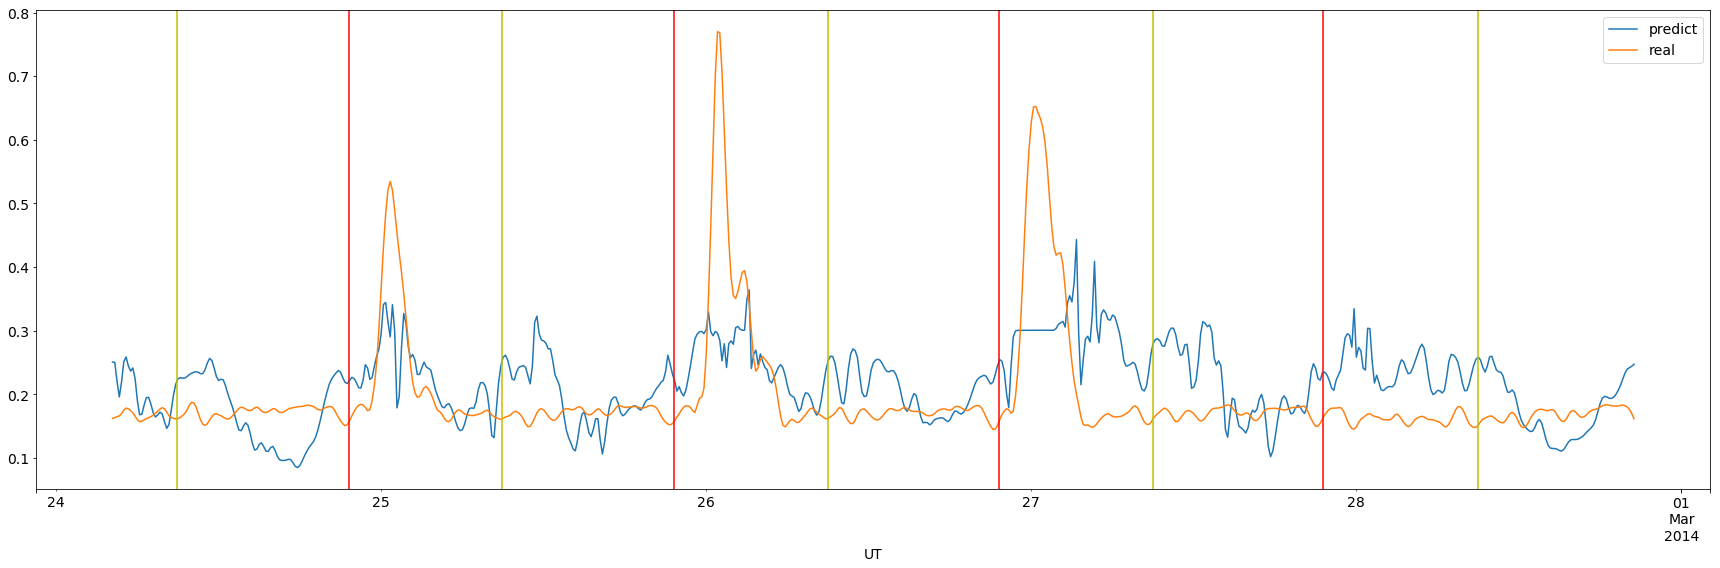

In [9]:
# generate model, use k-fold crossvalidation and print scores
model = SVR()
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print('The scores for the k-fold crossvalidation was:')
print(scores, '\n')

# generate final model, and avaliate a test set
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
give_error(y_test, y_predict);
print()

# use the final model to avaliate the error in a sample of the time series
df_aux = pd.DataFrame(index=index)
df_aux['predict'] = model.predict(X[12000:12772])
df_aux['real'] = y[12000:12772]

print('Error for the time series sample:')
give_error(df_aux['real'].values, df_aux['predict'].values);

# plot the time series predict against the real values
ax = df_aux.plot(figsize=(24, 8));
plt.xlabel('UT')

lat, long = location_station('sj2')
set_of_sunrise = find_set_sunrise(df_aux, lat, long)
set_of_sunset = find_set_sunset(df_aux, lat, long)
for i in set_of_sunrise:
    ax.axvline(x=i, color='y')
for i in set_of_sunset[0:-1]:
    ax.axvline(x=i, color='r')

plt.tight_layout()

## Sem derivada temporal segunda do VTEC

In [10]:
instances_set = ['vtec', 'vtec_dt', 'gvtec1', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt']
scaler = StandardScaler()
scaler.fit(X=df[instances_set].values) 
X = scaler.transform(X=df[instances_set].values)
y = df['s4'].values

X_train, X_test, y_train, y_test = train_test_split(X[0:12000], y[0:12000], test_size=0.30, random_state=42)
index = df.index.values[12000:12772]

The scores for the k-fold crossvalidation was:
[-0.00249127 -0.00252886 -0.00239285 -0.00263236 -0.002605   -0.00254888
 -0.00270456 -0.00224319 -0.00261264 -0.002537  ] 

O erro quadrático médio foi: 0.002463
O erro quadrático total foi: 2.977462
O maior erro por previsão foi: 0.247152
O erro relativo foi: 20.886832%
O número de verdadeiros negativos foi: 1770
O número de verdadeiros positivos foi: 371
O número de falsos negativos foi: 6
O número de falsos positivos foi: 1453
O POD foi: 0.984085
O FAR foi: 0.796601
A ACC foi: 0.594722
O kappa foi: 0.042414

Error for the time series sample:
O erro quadrático médio foi: 0.007821
O erro quadrático total foi: 2.297643
O maior erro por previsão foi: 0.455662
O erro relativo foi: 30.214922%
O número de verdadeiros negativos foi: 314
O número de verdadeiros positivos foi: 83
O número de falsos negativos foi: 1
O número de falsos positivos foi: 277
O POD foi: 0.988095
O FAR foi: 0.769444
A ACC foi: 0.588148
O kappa foi: 0.051150


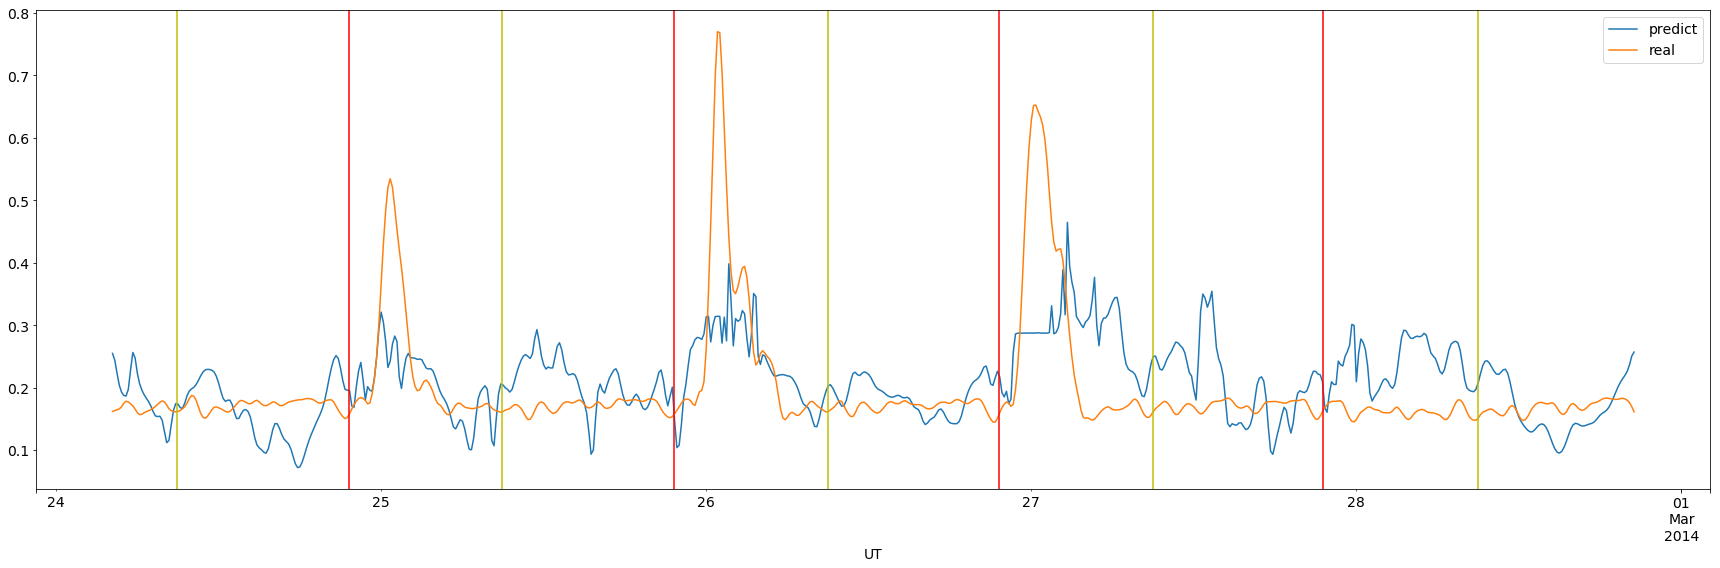

In [11]:
# generate model, use k-fold crossvalidation and print scores
model = SVR()
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print('The scores for the k-fold crossvalidation was:')
print(scores, '\n')

# generate final model, and avaliate a test set
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
give_error(y_test, y_predict);
print()

# use the final model to avaliate the error in a sample of the time series
df_aux = pd.DataFrame(index=index)
df_aux['predict'] = model.predict(X[12000:12772])
df_aux['real'] = y[12000:12772]

print('Error for the time series sample:')
give_error(df_aux['real'].values, df_aux['predict'].values);

# plot the time series predict against the real values
ax = df_aux.plot(figsize=(24, 8));
plt.xlabel('UT')

lat, long = location_station('sj2')
set_of_sunrise = find_set_sunrise(df_aux, lat, long)
set_of_sunset = find_set_sunset(df_aux, lat, long)
for i in set_of_sunrise:
    ax.axvline(x=i, color='y')
for i in set_of_sunset[0:-1]:
    ax.axvline(x=i, color='r')

plt.tight_layout()

## Sem gradiente do VTEC em relação à Pirassununga

In [12]:
instances_set = ['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt']
scaler = StandardScaler()
scaler.fit(X=df[instances_set].values) 
X = scaler.transform(X=df[instances_set].values)
y = df['s4'].values

X_train, X_test, y_train, y_test = train_test_split(X[0:12000], y[0:12000], test_size=0.30, random_state=42)
index = df.index.values[12000:12772]

The scores for the k-fold crossvalidation was:
[-0.00305877 -0.00319619 -0.00322569 -0.00324947 -0.0034141  -0.00334536
 -0.00326875 -0.00283451 -0.0032403  -0.00305393] 

O erro quadrático médio foi: 0.003029
O erro quadrático total foi: 3.302160
O maior erro por previsão foi: 0.316638
O erro relativo foi: 24.742668%
O número de verdadeiros negativos foi: 1275
O número de verdadeiros positivos foi: 361
O número de falsos negativos foi: 16
O número de falsos positivos foi: 1948
O POD foi: 0.957560
O FAR foi: 0.843655
A ACC foi: 0.454444
O kappa foi: 0.055835

Error for the time series sample:
O erro quadrático médio foi: 0.008695
O erro quadrático total foi: 2.422619
O maior erro por previsão foi: 0.477766
O erro relativo foi: 33.736594%
O número de verdadeiros negativos foi: 230
O número de verdadeiros positivos foi: 82
O número de falsos negativos foi: 2
O número de falsos positivos foi: 361
O POD foi: 0.976190
O FAR foi: 0.814898
A ACC foi: 0.462222
O kappa foi: 0.065980


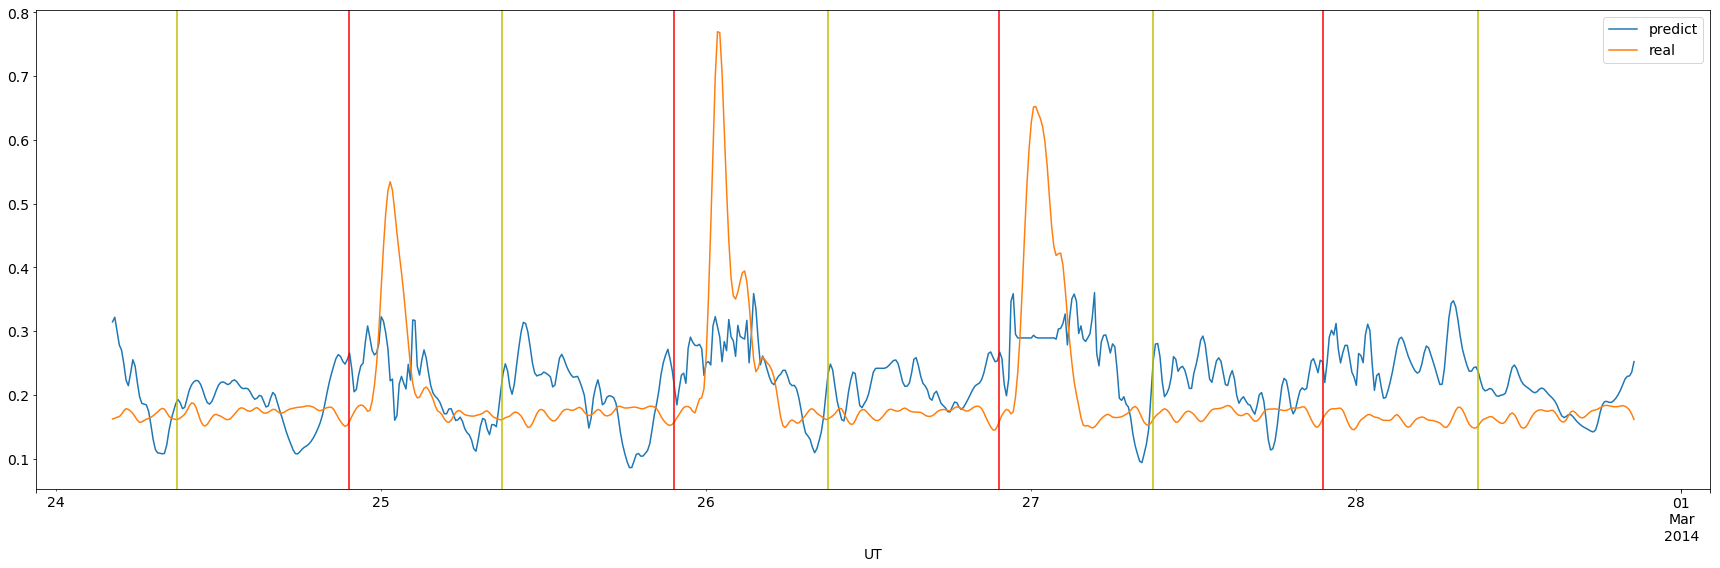

In [13]:
# generate model, use k-fold crossvalidation and print scores
model = SVR()
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print('The scores for the k-fold crossvalidation was:')
print(scores, '\n')

# generate final model, and avaliate a test set
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
give_error(y_test, y_predict);
print()

# use the final model to avaliate the error in a sample of the time series
df_aux = pd.DataFrame(index=index)
df_aux['predict'] = model.predict(X[12000:12772])
df_aux['real'] = y[12000:12772]

print('Error for the time series sample:')
give_error(df_aux['real'].values, df_aux['predict'].values);

# plot the time series predict against the real values
ax = df_aux.plot(figsize=(24, 8));
plt.xlabel('UT')

lat, long = location_station('sj2')
set_of_sunrise = find_set_sunrise(df_aux, lat, long)
set_of_sunset = find_set_sunset(df_aux, lat, long)
for i in set_of_sunrise:
    ax.axvline(x=i, color='y')
for i in set_of_sunset[0:-1]:
    ax.axvline(x=i, color='r')

plt.tight_layout()

## Sem derivada temporal do gradiente do VTEC em relação à Pirassununga

In [14]:
instances_set = ['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec2', 'gvtec2_dt']
scaler = StandardScaler()
scaler.fit(X=df[instances_set].values) 
X = scaler.transform(X=df[instances_set].values)
y = df['s4'].values

X_train, X_test, y_train, y_test = train_test_split(X[0:12000], y[0:12000], test_size=0.30, random_state=42)
index = df.index.values[12000:12772]

The scores for the k-fold crossvalidation was:
[-0.00285549 -0.00268401 -0.0027528  -0.00297103 -0.00265897 -0.00298847
 -0.00297511 -0.00254579 -0.00273989 -0.00274171] 

O erro quadrático médio foi: 0.002639
O erro quadrático total foi: 3.082379
O maior erro por previsão foi: 0.366675
O erro relativo foi: 22.290286%
O número de verdadeiros negativos foi: 1275
O número de verdadeiros positivos foi: 358
O número de falsos negativos foi: 19
O número de falsos positivos foi: 1948
O POD foi: 0.949602
O FAR foi: 0.844753
A ACC foi: 0.453611
O kappa foi: 0.055680

Error for the time series sample:
O erro quadrático médio foi: 0.008195
O erro quadrático total foi: 2.351981
O maior erro por previsão foi: 0.473018
O erro relativo foi: 29.758740%
O número de verdadeiros negativos foi: 296
O número de verdadeiros positivos foi: 80
O número de falsos negativos foi: 4
O número de falsos positivos foi: 295
O POD foi: 0.952381
O FAR foi: 0.786667
A ACC foi: 0.557037
O kappa foi: 0.054396


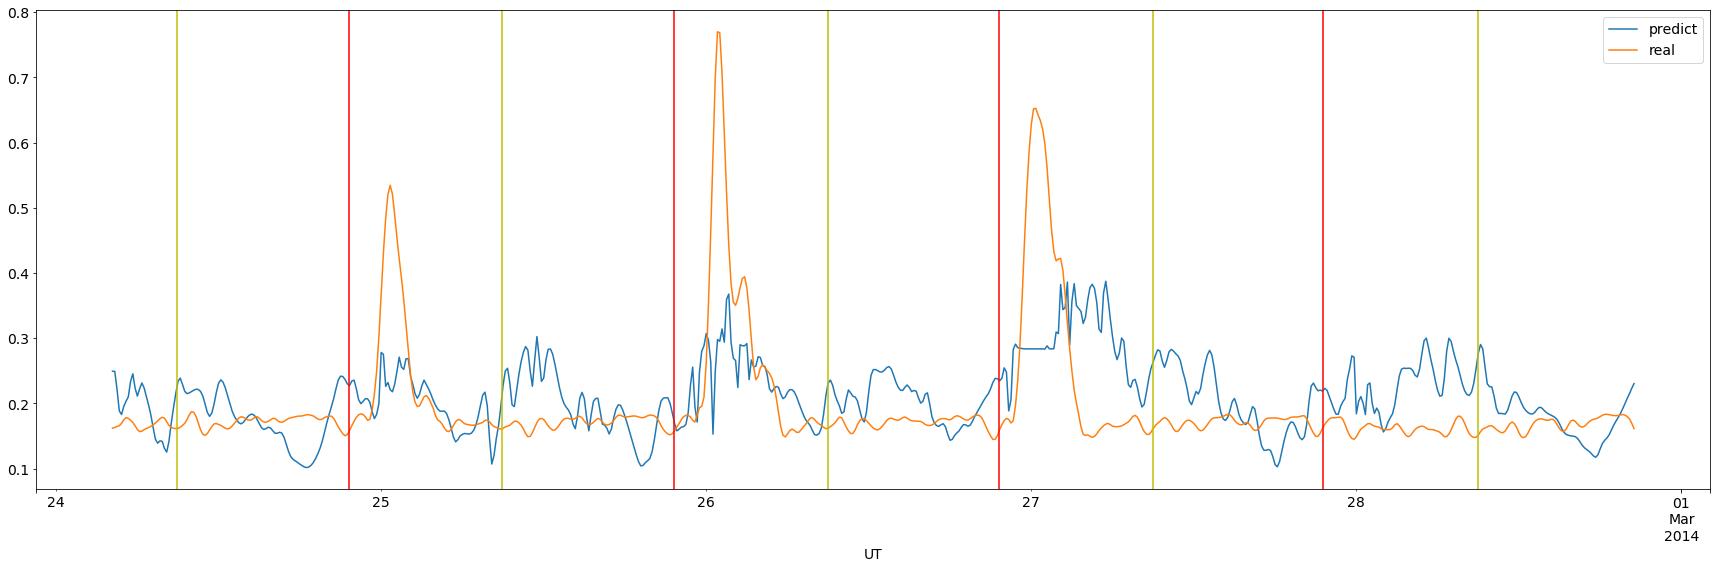

In [15]:
# generate model, use k-fold crossvalidation and print scores
model = SVR()
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print('The scores for the k-fold crossvalidation was:')
print(scores, '\n')

# generate final model, and avaliate a test set
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
give_error(y_test, y_predict);
print()

# use the final model to avaliate the error in a sample of the time series
df_aux = pd.DataFrame(index=index)
df_aux['predict'] = model.predict(X[12000:12772])
df_aux['real'] = y[12000:12772]

print('Error for the time series sample:')
give_error(df_aux['real'].values, df_aux['predict'].values);

# plot the time series predict against the real values
ax = df_aux.plot(figsize=(24, 8));
plt.xlabel('UT')

lat, long = location_station('sj2')
set_of_sunrise = find_set_sunrise(df_aux, lat, long)
set_of_sunset = find_set_sunset(df_aux, lat, long)
for i in set_of_sunrise:
    ax.axvline(x=i, color='y')
for i in set_of_sunset[0:-1]:
    ax.axvline(x=i, color='r')

plt.tight_layout()

## Sem gradiente do VTEC em relação à Brasília

In [16]:
instances_set = ['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2_dt']
scaler = StandardScaler()
scaler.fit(X=df[instances_set].values) 
X = scaler.transform(X=df[instances_set].values)
y = df['s4'].values

X_train, X_test, y_train, y_test = train_test_split(X[0:12000], y[0:12000], test_size=0.30, random_state=42)
index = df.index.values[12000:12772]

The scores for the k-fold crossvalidation was:
[-0.00294977 -0.0029794  -0.00303885 -0.00313385 -0.00342169 -0.00346879
 -0.00276783 -0.00283871 -0.00296284 -0.00278893] 

O erro quadrático médio foi: 0.002894
O erro quadrático total foi: 3.227811
O maior erro por previsão foi: 0.276437
O erro relativo foi: 23.046470%
O número de verdadeiros negativos foi: 1164
O número de verdadeiros positivos foi: 370
O número de falsos negativos foi: 7
O número de falsos positivos foi: 2059
O POD foi: 0.981432
O FAR foi: 0.847674
A ACC foi: 0.426111
O kappa foi: 0.059412

Error for the time series sample:
O erro quadrático médio foi: 0.009123
O erro quadrático total foi: 2.481509
O maior erro por previsão foi: 0.553862
O erro relativo foi: 34.385721%
O número de verdadeiros negativos foi: 179
O número de verdadeiros positivos foi: 80
O número de falsos negativos foi: 4
O número de falsos positivos foi: 412
O POD foi: 0.952381
O FAR foi: 0.837398
A ACC foi: 0.383704
O kappa foi: 0.073912


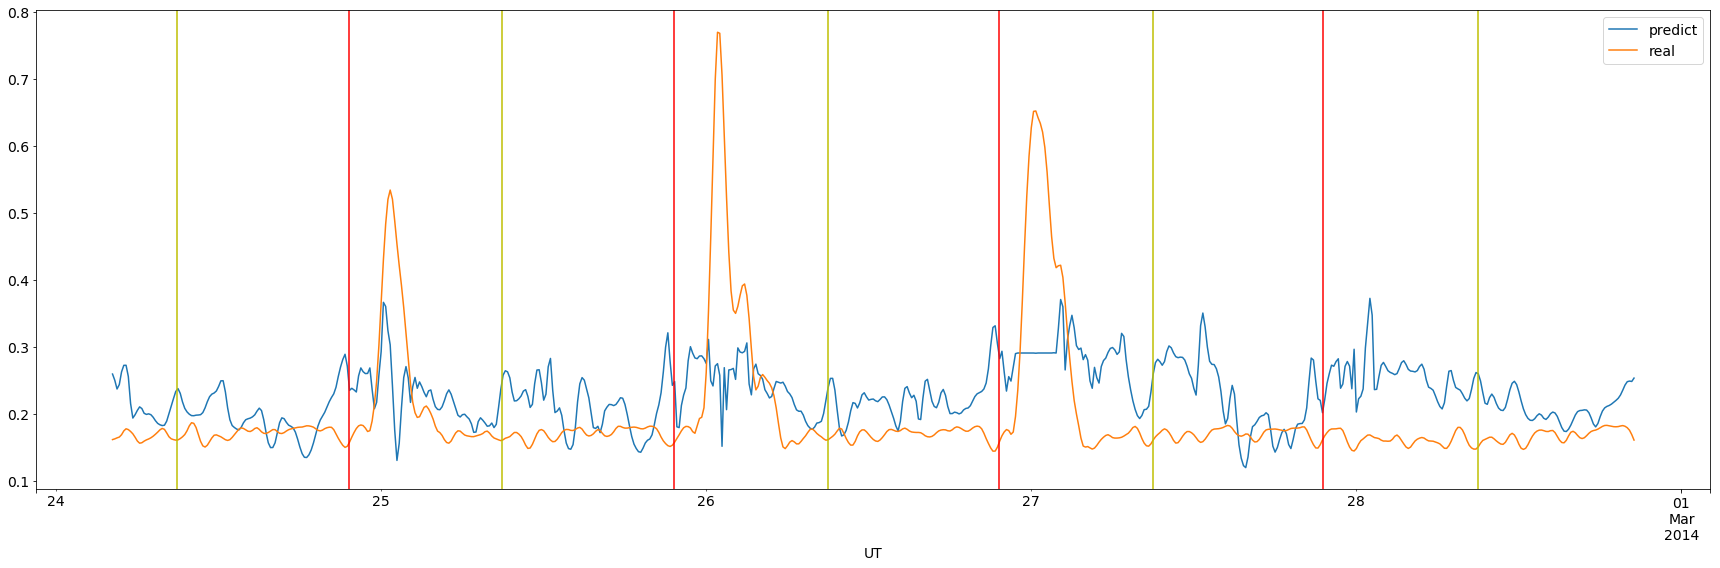

In [17]:
# generate model, use k-fold crossvalidation and print scores
model = SVR()
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print('The scores for the k-fold crossvalidation was:')
print(scores, '\n')

# generate final model, and avaliate a test set
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
give_error(y_test, y_predict);
print()

# use the final model to avaliate the error in a sample of the time series
df_aux = pd.DataFrame(index=index)
df_aux['predict'] = model.predict(X[12000:12772])
df_aux['real'] = y[12000:12772]

print('Error for the time series sample:')
give_error(df_aux['real'].values, df_aux['predict'].values);

# plot the time series predict against the real values
ax = df_aux.plot(figsize=(24, 8));
plt.xlabel('UT')

lat, long = location_station('sj2')
set_of_sunrise = find_set_sunrise(df_aux, lat, long)
set_of_sunset = find_set_sunset(df_aux, lat, long)
for i in set_of_sunrise:
    ax.axvline(x=i, color='y')
for i in set_of_sunset[0:-1]:
    ax.axvline(x=i, color='r')

plt.tight_layout()

## Sem derivada temporal do gradiente do VTEC em relação à Brasília

In [18]:
instances_set = ['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2']
scaler = StandardScaler()
scaler.fit(X=df[instances_set].values) 
X = scaler.transform(X=df[instances_set].values)
y = df['s4'].values

X_train, X_test, y_train, y_test = train_test_split(X[0:12000], y[0:12000], test_size=0.30, random_state=42)
index = df.index.values[12000:12772]

The scores for the k-fold crossvalidation was:
[-0.00282273 -0.00296804 -0.00264677 -0.00270707 -0.00280755 -0.00290625
 -0.0029653  -0.00256654 -0.00274855 -0.00263048] 

O erro quadrático médio foi: 0.002721
O erro quadrático total foi: 3.130000
O maior erro por previsão foi: 0.253909
O erro relativo foi: 22.909347%
O número de verdadeiros negativos foi: 1487
O número de verdadeiros positivos foi: 367
O número de falsos negativos foi: 10
O número de falsos positivos foi: 1736
O POD foi: 0.973475
O FAR foi: 0.825487
A ACC foi: 0.515000
O kappa foi: 0.050307

Error for the time series sample:
O erro quadrático médio foi: 0.007669
O erro quadrático total foi: 2.275202
O maior erro por previsão foi: 0.479197
O erro relativo foi: 29.547460%
O número de verdadeiros negativos foi: 312
O número de verdadeiros positivos foi: 82
O número de falsos negativos foi: 2
O número de falsos positivos foi: 279
O POD foi: 0.976190
O FAR foi: 0.772853
A ACC foi: 0.583704
O kappa foi: 0.051582


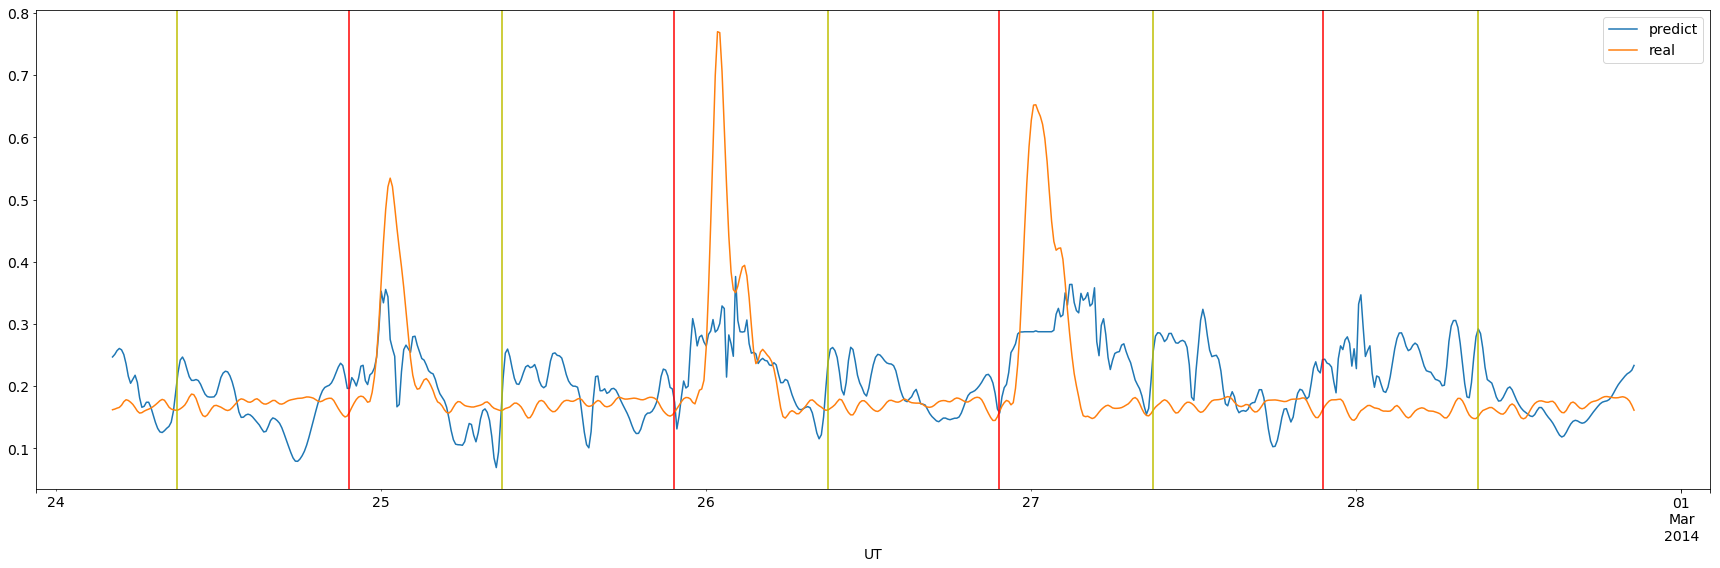

In [19]:
# generate model, use k-fold crossvalidation and print scores
model = SVR()
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print('The scores for the k-fold crossvalidation was:')
print(scores, '\n')

# generate final model, and avaliate a test set
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
give_error(y_test, y_predict);
print()

# use the final model to avaliate the error in a sample of the time series
df_aux = pd.DataFrame(index=index)
df_aux['predict'] = model.predict(X[12000:12772])
df_aux['real'] = y[12000:12772]

print('Error for the time series sample:')
give_error(df_aux['real'].values, df_aux['predict'].values);

# plot the time series predict against the real values
ax = df_aux.plot(figsize=(24, 8));
plt.xlabel('UT')

lat, long = location_station('sj2')
set_of_sunrise = find_set_sunrise(df_aux, lat, long)
set_of_sunset = find_set_sunset(df_aux, lat, long)
for i in set_of_sunrise:
    ax.axvline(x=i, color='y')
for i in set_of_sunset[0:-1]:
    ax.axvline(x=i, color='r')

plt.tight_layout()